In [1]:
!pip install scikit-plot

In [2]:
# import all libraries
# Train/Test Libraries

import os
import numpy as np
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import scikitplot
from sklearn.metrics import roc_curve, auc

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
os.getcwd()

'/kaggle/working'

In [4]:
dataDir = '/kaggle/input/mmds-cxr'
train_x = np.load(dataDir+'/train_images.npy')
train_y = np.load(dataDir+'/train_labels.npy')
test_x = np.load(dataDir+'/test_images.npy')
test_y = np.load(dataDir+'/test_labels.npy')

print('Training Images: {} | Test Images: {}'.format(train_x.shape, test_x.shape))
print('Training Labels: {} | Test Labels: {}'.format(train_y.shape, test_y.shape))

# Data Normalization

print('Train: {} , {} | Test: {} , {}'.format(train_x.min(), train_x.max(), test_x.min(), test_x.max()))

train_x/=255.0
test_x/=255.0

print('Train: {} , {} | Test: {} , {}'.format(train_x.min(), train_x.max(), test_x.min(), test_x.max()))

Training Images: (14925, 224, 224, 3) | Test Images: (231, 224, 224, 3)
Training Labels: (14925,) | Test Labels: (231,)
Train: 0.0 , 255.0 | Test: 0.0 , 255.0
Train: 0.0 , 1.0 | Test: 0.0 , 1.0


In [5]:
# Class Mapping 
print('0:Normal | 1:Pneumonia | 2:COVID-19')

# Distribution of images in each class for Training-set
print(Counter(train_y))

# Distribution of images in each class for Test-set
print(Counter(test_y))

#Make Labels Categorical
train_y_oneHot = tf.one_hot(train_y, depth=3) 
test_y_oneHot = tf.one_hot(test_y, depth=3)

print('Training Labels: {} | Test Labels: {}'.format(train_y_oneHot.shape, test_y_oneHot.shape))

0:Normal | 1:Pneumonia | 2:COVID-19
Counter({0: 8751, 1: 5945, 2: 229})
Counter({0: 100, 1: 100, 2: 31})
Training Labels: (14925, 3) | Test Labels: (231, 3)


In [6]:
# initialize the training data augmentation object
trainAug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=15, fill_mode="nearest")

def MobileNetV2_Model():
    # load the VGG16 network, ensuring the head FC layer sets are left off
    baseModel = tf.keras.applications.nasnet.NASNetMobile(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    # construct the head of the model that will be placed on top of the the base model
    output = baseModel.output
    output = tf.keras.layers.GlobalAveragePooling2D()(output)
    output = tf.keras.layers.Dense(1024, activation="relu")(output)
    output = tf.keras.layers.Dense(512, activation="relu")(output)
    output = tf.keras.layers.Dense(3, activation="softmax")(output)
    # place the head FC model on top of the base model (this will become the actual model we will train)
    model = tf.keras.Model(inputs=baseModel.input, outputs=output)
    # loop over all layers in the base model and freeze them so they will not be updated during the first training process
    for layer in baseModel.layers:
        layer.trainable = False
    return model

model = MobileNetV2_Model()
# compile our model
print("[INFO] compiling model...")
# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 0.001
EPOCHS = 50
BATCHSIZE = 32 
optimizer = tf.keras.optimizers.Adam(lr=INIT_LR, weight_decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC()])
print(model.summary())

19993432/19993432 [==============================] - 1s 0us/step
[INFO] compiling model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv1 (Conv2D)         (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 stem_bn1 (BatchNormalizati  (None, 111, 111, 32)         128       ['stem_conv1[0][0]']          
 on)                                                                                              
                                                                                                  
 ac

In [7]:
modelPath = '/kaggle/working/Model'
if not os.path.exists(modelPath):
    os.makedirs(modelPath)
    print('Model Directory Created')
else:
    print('Model Directory Already Exists')

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(modelPath+'/nasnetmobile-best-model.h5', monitor='val_categorical_accuracy',
                                                      verbose=1, save_best_only=True, mode='auto')

STEP_TRAIN = len(train_x) // BATCHSIZE
STEP_TEST = len(test_x) // BATCHSIZE
modelHistory = model.fit(trainAug.flow(train_x, train_y_oneHot, batch_size=BATCHSIZE), epochs=EPOCHS, verbose=1, callbacks=[model_checkpoint],
                         validation_data=(test_x, test_y_oneHot), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_TEST)
tf.keras.models.save_model(model, modelPath+'/nasnetmobile-model.h5', overwrite=True, include_optimizer=True, save_format=None,
                           signatures=None, options=None)

Model Directory Created
Epoch 1/50
466/466 [==============================] - ETA: 0s - loss: 0.3890 - categorical_accuracy: 0.8554 - auc: 0.9567
Epoch 1: val_categorical_accuracy improved from -inf to 0.77056, saving model to /kaggle/working/Model/nasnetmobile-best-model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


466/466 [==============================] - 168s 318ms/step - loss: 0.3890 - categorical_accuracy: 0.8554 - auc: 0.9567 - val_loss: 0.6817 - val_categorical_accuracy: 0.7706 - val_auc: 0.9109
Epoch 2/50
466/466 [==============================] - ETA: 0s - loss: 0.3163 - categorical_accuracy: 0.8815 - auc: 0.9705
Epoch 2: val_categorical_accuracy improved from 0.77056 to 0.77922, saving model to /kaggle/working/Model/nasnetmobile-best-model.h5
466/466 [==============================] - 143s 307ms/step - loss: 0.3163 - categorical_accuracy: 0.8815 - auc: 0.9705 - val_loss: 0.5391 - val_categorical_accuracy: 0.7792 - val_auc: 0.9290
Epoch 3/50
466/466 [==============================] - ETA: 0s - loss: 0.3094 - categorical_accuracy: 0.8864 - auc: 0.9717
Epoch 3: val_categorical_accuracy improved from 0.77922 to 0.84416, saving model to /kaggle/working/Model/nasnetmobile-best-model.h5
466/466 [==============================] - 142s 305ms/step - loss: 0.3094 - categorical_accuracy: 0.8864 - a

/tmp/ipykernel_42/4156424009.py:15: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, modelPath+'/nasnetmobile-model.h5', overwrite=True, include_optimizer=True, save_format=None,


In [8]:
os.getcwd()

'/kaggle/working'

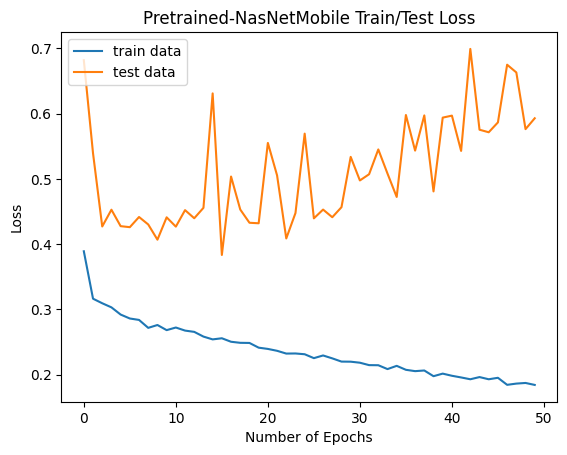

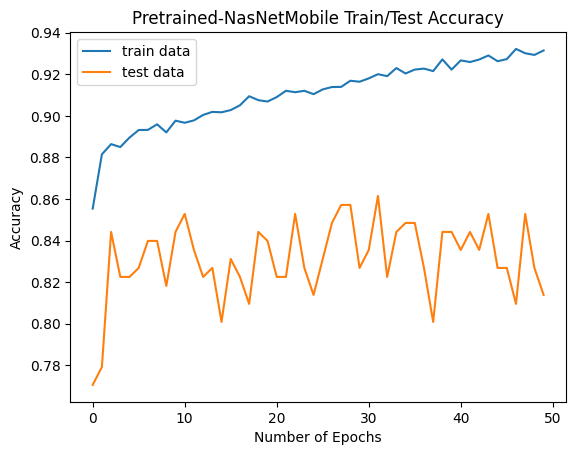

In [9]:
import matplotlib.pyplot as plt
losshistoryPath = './Train-Test History/Loss'
acchistoryPath = './Train-Test History/Accuracy'
if not os.path.exists(losshistoryPath) or not os.path.exists(acchistoryPath):
    os.makedirs(losshistoryPath)
    os.makedirs(acchistoryPath)
  
# Plot history: Loss
plt.plot(modelHistory.history['loss'], label='train data')
plt.plot(modelHistory.history['val_loss'], label='test data')
plt.title('Pretrained-NasNetMobile Train/Test Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend(loc="upper left")
plt.savefig('./Train-Test History/Loss/Pretrained-NasNetMobile-loss-Graph.png', bbox_inches = "tight")
plt.show()

# Plot history: Accuracy
plt.plot(modelHistory.history['categorical_accuracy'], label='train data')
plt.plot(modelHistory.history['val_categorical_accuracy'], label='test data')
plt.title('Pretrained-NasNetMobile Train/Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(loc="upper left")
plt.savefig('./Train-Test History/Accuracy/NasNetMobile-Accuracy-Graph.png', bbox_inches = "tight")
plt.show()

In [10]:
# Evaluate the Best Saved Model
model = tf.keras.models.load_model('/kaggle/working/Model/nasnetmobile-best-model.h5')
loss, accuracy, auc = model.evaluate(x=test_x, y=test_y_oneHot, batch_size=32, verbose=1)
print('Model Accuracy: {:0.2f} | Model AUC: {:0.2f} | Model Loss: {:0.4f}'.format(accuracy, auc, loss))

8/8 [==============================] - 5s 90ms/step - loss: 0.5070 - categorical_accuracy: 0.8615 - auc: 0.9525
Model Accuracy: 0.86 | Model AUC: 0.95 | Model Loss: 0.5070


8/8 [==============================] - 4s 49ms/step


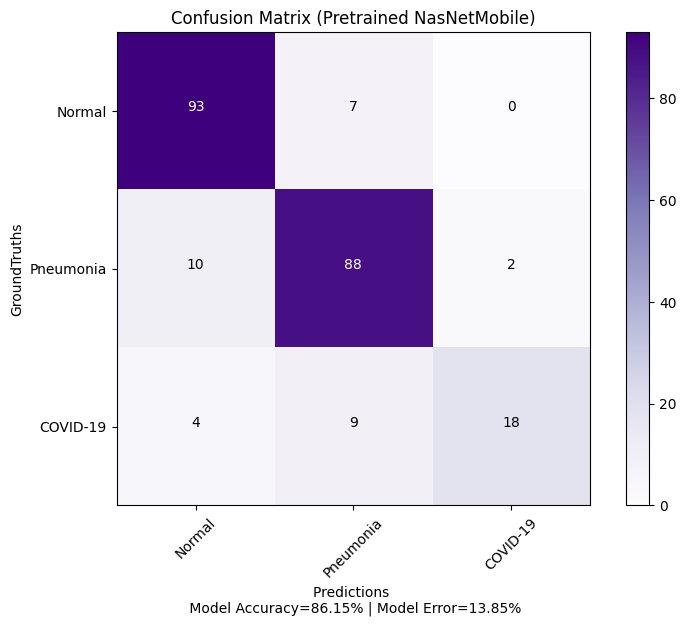

In [11]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Purples')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('GroundTruths')
    plt.xlabel('Predictions \n Model Accuracy={:0.2f}% | Model Error={:0.2f}%'.format(accuracy*100, misclass*100))
    plt.savefig('./nasnetmobile-cm.png', bbox_inches = "tight")
    plt.show()


predictions = model.predict(x=test_x, batch_size=32)
predictions = tf.keras.backend.argmax(predictions, axis=-1)

cm = confusion_matrix(test_y, predictions)
classes = ['Normal', 'Pneumonia', 'COVID-19']
plot_confusion_matrix(cm=cm, normalize = False, target_names = classes, title= "Confusion Matrix (Pretrained NasNetMobile)")

8/8 [==============================] - 0s 49ms/step


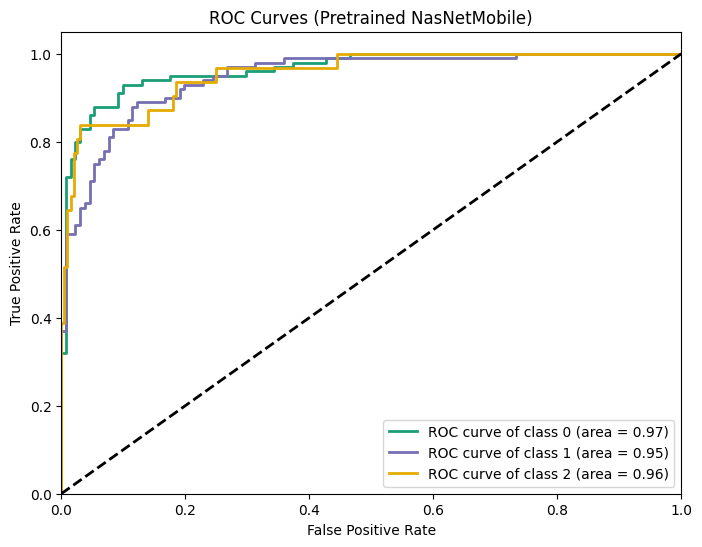

In [12]:
#Plot ROC Curve with Library
predictions = model.predict(x=test_x, batch_size=32)
# One can define colormap here
# cmap = mpl.colors.ListedColormap(['red', 'green', 'blue', 'cyan'])
scikitplot.metrics.plot_roc(y_true=test_y, y_probas=predictions, title='ROC Curves (Pretrained NasNetMobile)', plot_micro=False, plot_macro=False,
                            classes_to_plot=None, ax=None, figsize=(8, 6), cmap='Dark2', title_fontsize='large', text_fontsize='medium')
plt.savefig('./nasnetmobile-roc.png', bbox_inches = "tight")
plt.show()